# TABLE OF CONTENTS:
* [Workspace](#Workspace)
* [Data](#Data)
* [Compute Target](#Compute-Target)
* [Training Artifacts & Configuration](#Training-Artifacts-&-Configuration)
* [Development Environment](#Development-Environment)
* [Compute Target](#Compute-Target)
* [Development Environment](#Development-Environment)
* [Experiment & Run Configuration](#Experiment-&-Run-Configuration)
* [Model Registration](#Model-Registration)
* [Resource Clean Up](#Resource-Clean-Up)

In [5]:
import azureml.core
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Dataset, Environment, Experiment, Model, ScriptRunConfig, Workspace
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig 
from azureml.widgets import RunDetails

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.19.0


# Workspace

### Option 1: Create Workspace from Config

In [12]:
ws = Workspace.from_config() # this automatically looks for a directory .azureml

# ws.get_details()

### Option 2: Create Workspace from Connection Info

In [ ]:
# ws = Workspace.get(name="sbirk-aml-ws",
#                    subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
#                    resource_group="sbirk-aml-rg") 

# ws.get_details()

# Data

### Download Data

Use the Pytorch dataset and dataloader classes to download the cifar10 data to the local compute.

In [7]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create train dataset and dataloader
trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


### Explore Data

Display the first batch of 4 CIFAR10 images.

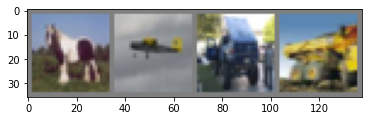

      horse       plane       truck       truck


In [11]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(" ".join("%11s" % classes[labels[j]] for j in range(4)))

### Upload Data

Upload the data to the default AML datastore.

In [ ]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir="./data", target_path="data/cifar10", overwrite=True)

### Create and Register AML Dataset

In [ ]:
# Create a dataset object from datastore location
dataset = Dataset.File.from_files(path=(datastore, "data/cifar10"))

# Register the dataset
dataset = dataset.register(workspace=ws,
                           name="cifar10-dataset",
                           description="cifar10 training dataset",
                           create_new_version=True)

# Compute Target

In [6]:
# Choose a name for the CPU cluster
cpu_cluster_name = "msai-ds3v2-04"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                            max_nodes=4, 
                                                            idle_seconds_before_scaledown=2400)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Training Artifacts & Configuration

In [7]:
# Create a folder for the training artifacts
training_folder = os.path.join(os.getcwd(), "training")
os.makedirs(training_folder, exist_ok=True)

In the following cell, the training script is created.

%%writefile $training_folder/train.py
import os
import argparse
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from model import Net
from azureml.core import Run

run = Run.get_context()

if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--data_path",
        type=str,
        help="Path to the training data"
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=0.001,
        help="Learning rate for SGD"
    )
    parser.add_argument(
        "--momentum",
        type=float,
        default=0.9,
        help="Momentum for SGD"
    )

    args = parser.parse_args()

    print("===== DATA =====")
    print("DATA PATH: " + args.data_path)
    print("LIST FILES IN DATA PATH...")
    print(os.listdir(args.data_path))
    print("================")

    # Prepare DataLoader for CIFAR10 data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(
        root=args.data_path,
        train=True,
        download=False,
        transform=transform,
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )

    # Define convolutional network
    net = Net()

    # Set up pytorch loss / optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=args.learning_rate,
        momentum=args.momentum,
    )

    # Train the network
    for epoch in range(2):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data # unpack the data

            optimizer.zero_grad() # zero the parameter gradients

            # Run forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                loss = running_loss / 2000
                run.log("loss", loss) # log loss metric to AML
                print(f"epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}")
                running_loss = 0.0

    print("Finished training")

    PATH = "cifar_net.pt"
    torch.save(net.state_dict(), PATH)
    run.upload_file(name=PATH, path_or_stream=PATH)
    
    print("Saved and uploaded model")

Run the training script locally.

In [ ]:
# !python training/train.py --data_path ./data --learning_rate 0.003 --momentum 0.92

# Development Environment

In [14]:
# # Display AML Curated Environments
# # Curated environments are backed by cached Docker images, reducing the run preparation cost.
# envs = Environment.list(workspace=ws)

# for env in envs:
#     if env.startswith("AzureML"):
#         print("Name", env)
#         print("packages", envs[env].python.conda_dependencies.serialize_to_string())

In [22]:
# # List workspace environments
# for name, env in ws.environments.items():
#     print(f"Name {name} \t version {env.version}")

# # Retrieve an environment
# env = Environment.get(workspace=ws, name="AzureML-PyTorch-1.3-CPU", version="1")

# # Get base image of retrieved environment
# print(env.docker.base_image)

# print("\n Attributes of retrieved environment:")
# env

In [12]:
# On the first run in a given environment, Azure ML spends some time building the environment.
# On the subsequent runs, Azure ML keeps track of changes and uses the existing environment, 
# resulting in faster run completion.

# Create environment from yml file
env = Environment.from_conda_specification(name="pytorch-aml-env",
                                           file_path="environment.yml")

# Attribute docker.enabled controls whether to use Docker container or host OS for execution.
# This is only relevant for local execution as execution on AML Compute Cluster will always use Docker container.
env.docker.enabled = True

# Use Python dependencies from your Docker image (as opposed to from conda specification)
# env.python.user_managed_dependencies=True

# OPTION 1: Use mcr base image
env.docker.base_image = "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1"

# OPTION 2: Use custom base image
#env.docker.base_image = "myregistry.azurecr.io/mycustomimage:1.0"
#env.docker.base_image_registry.address = "myregistry.azurecr.io"
#env.docker.base_image_registry.username = "username"
#env.docker.base_image_registry.password = "password"

# Create an environment variable.
# This can be retrieved in the training script with os.environ.get("MESSAGE").
# env.environment_variables = {"MESSAGE": "Hello from Azure Machine Learning"}

env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "MESSAGE": "Hello from Azure Machine Learning"
    },
    "inferencingStackVersion": null,
    "name": "pytorch-aml-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "pytorch"
            ],
  

# Experiment & Run Configuration

In [13]:
# Create the experiment
experiment = Experiment(workspace=ws, 
                        name="cifar-image-classification-pytorch")

# Create the script run configuration
config = ScriptRunConfig(source_directory="training",
                         script="train.py",
                         compute_target=cpu_cluster_name,
                         arguments=[
                             "--data_path", dataset.as_named_input("input").as_mount(),
                             "--learning_rate", 0.003,
                             "--momentum", 0.92])

config.run_config.environment = env

# Submit the run
run = experiment.submit(config)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [14]:
run.wait_for_completion(show_output=False)

{'runId': 'cifar-image-classification-pytorch_1610022440_3a9fb6fe',
 'target': 'msai-ds3v2-04',
 'status': 'Completed',
 'startTimeUtc': '2021-01-07T12:43:43.235687Z',
 'endTimeUtc': '2021-01-07T12:48:47.470045Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'ca023c5d-fc8c-4744-9860-825235f9dc10',
  'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '61e3ec522ae2e1c49c333de6dc04eafe472f2858',
  'mlflow.source.git.commit': '61e3ec522ae2e1c49c333de6dc04eafe472f2858',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '454d0a25-97df-4ef8-8a7c-58fc967448d6'}, 'consumptionDetails': {'

In [15]:
# Check run metrics and file names
print(run.get_metrics())
print(run.get_file_names())

{'loss': [2.0413564110696316, 1.7357404006272554, 1.6161067148000001, 1.5915769870132208, 1.5596799415498972, 1.5253833034932613, 1.474745139680803, 1.5081596463024616, 1.4987276076860725, 1.5030428788289427, 1.5029170999862254, 1.4870155130643397]}
['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/65_job_prep-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'cifar_net.pt', 'logs/azureml/79_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_565d07a1-9849-4fff-b50f-f815a0065d23.jsonl', 'logs/azureml/dataprep/engine_spans_e5a231dc-b108-

# Model Registration

In [16]:
model_path = "cifar_net.pt"

model = run.register_model(model_name="cifar10-model",
                           model_path=model_path,
                           model_framework=Model.Framework.PYTORCH,
                           description="cifar10 model")

# Resource Clean Up

In [ ]:
# cpu_cluster.delete()

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/get-started-day1/day1-part4-data.png)

In [18]:
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="your-tenant-id")
Additional details on authentication can be found here: https://aka.ms/aml-notebook-auth 

SyntaxError: invalid syntax (<ipython-input-18-aa630af4f9d4>, line 3)